# 1  Mod 4 Project: Natural Language Processing (NLP) -  Working Copy

### Improving online conversation: Use of NLP analysis to build a multi-headed model capable of detecting different types of online discussion toxicity like threats, obscenity, insults, and identity-based hate.



   Student name: Andi Osika  
 * Student pace: part time
 * Scheduled project review date/time: TBD
 * Instructor name: James Irving, PhD
 * Blog post URL: tbd

## Project Quick Links:
**Link** | **Description**
--| --|
[Background](#Background:) | Details around the subject, datasource and objective
[Preprocessing](#Preprocessing:) | Steps taken to prepare data for modeling and evaluation
[Main Dataset](#Main-Dataset:) | The dataset in it's final form used for the predictive modeling results described in the [Conclusion](#Conclusion:)  section
[Modeling](#Modeling:) | Various iterations of predictive classification modeling including Decision Trees, Random Forest and XGBoost
[Best Model](#BEST-MODEL:-Manually-Tuned-Random-Forest) |Random Forest Classification Model including [Visualizations]() Confusion Matrix, ROC Curve, Feature Importance by Rank, Correlations
    [Conclusion](#Conclusion:) | Summation of outcomes from modeling

## Background:

Freedom of speech is a right.  Digital platforms facilitate conversations but struggle to efficiently do so in a way that facilitates this freedom in a way that minimizes the threat of online abuse and harrasment that can come with the 'anonymity effect' of a virtual climate.   

This dataset is provided by [Conversation AI ](https://conversationai.github.io/) is a collaborative research effort exploring ML as a tool for better discussions online.  The source is a dataset of comments from Wikipedia’s talk page edits. 

A classification list of 159,571 samples is provided of Wikipedia comments which have been labeled by human raters for toxic behavior. 

>The types of toxicity are:
* toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

In [268]:
from numpy.random import seed
seed(0)

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

### Data Import: Trainging and Testing DataSets

#### Test

In [2]:
test = pd.read_csv('test.csv', index_col='id')
test.head()

comment_text
id                                                                 
00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
0000247867823ef7  == From RfC == \n\n The title is fine as it is...
00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
00017563c3f7919a  :If you have a look back at the source, the in...
00017695ad8997eb          I don't anonymously edit articles at all.

In [3]:
X_test = test['comment_text']

In [4]:
y_test = pd.read_csv('test_labels.csv', index_col='id')

In [5]:
y_test.head()

toxic  severe_toxic  obscene  threat  insult  identity_hate
id                                                                           
00001cee341fdb12     -1            -1       -1      -1      -1             -1
0000247867823ef7     -1            -1       -1      -1      -1             -1
00013b17ad220c46     -1            -1       -1      -1      -1             -1
00017563c3f7919a     -1            -1       -1      -1      -1             -1
00017695ad8997eb     -1            -1       -1      -1      -1             -1

In [6]:
y_test = y_test[y_test.sum(axis=1)!=-6]
y_test.head()

toxic  severe_toxic  obscene  threat  insult  identity_hate
id                                                                           
0001ea8717f6de06      0             0        0       0       0              0
000247e83dcc1211      0             0        0       0       0              0
0002f87b16116a7f      0             0        0       0       0              0
0003e1cccfd5a40a      0             0        0       0       0              0
00059ace3e3e9a53      0             0        0       0       0              0

In [7]:
val_counts_test = y_test.apply(pd.Series.value_counts)
val_counts_test

toxic  severe_toxic  obscene  threat  insult  identity_hate
0  57888         63611    60287   63767   60551          63266
1   6090           367     3691     211    3427            712

In [8]:
val_counts_test.head(2).plot(kind='bar',figsize=(10,8))

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/55975

#### Train

In [9]:
train = pd.read_csv('train.csv')
train.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

In [10]:
X = train['comment_text']

In [11]:
target_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[target_classes]

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [14]:
val_counts = y_train.apply(pd.Series.value_counts)
val_counts

toxic  severe_toxic  obscene  threat  insult  identity_hate
0  108204        118467   113329  119322  113782         118647
1   11474          1211     6349     356    5896           1031

In [15]:
y_train.describe()

toxic   severe_toxic        obscene         threat  \
count  119678.000000  119678.000000  119678.000000  119678.000000   
mean        0.095874       0.010119       0.053051       0.002975   
std         0.294420       0.100083       0.224136       0.054459   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

              insult  identity_hate  
count  119678.000000  119678.000000  
mean        0.049266       0.008615  
std         0.216423       0.092416  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         1.000000       1.000000

In [16]:
# check for any 'null' comment
no_comment = X_train.isnull().value_counts()
len(no_comment)

1

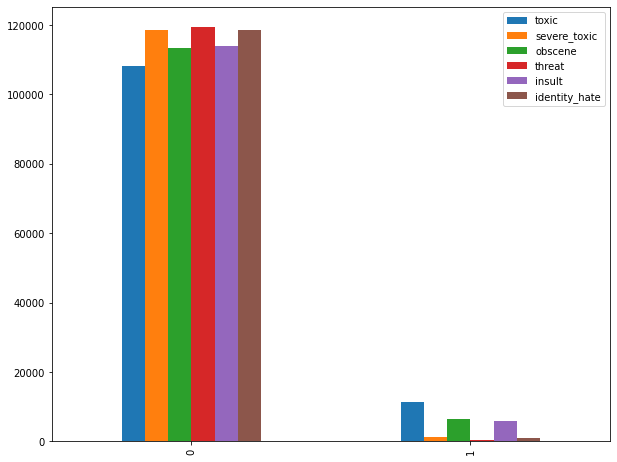

In [17]:
val_counts = y_train.apply(pd.Series.value_counts)
val_counts.head(2).plot(kind='bar',figsize=(10,8))

In [18]:
##develop the viz above to illustrate

In [19]:
value_counts_train = round(val_counts.head(2).T)
value_counts_train

0      1
toxic          108204  11474
severe_toxic   118467   1211
obscene        113329   6349
threat         119322    356
insult         113782   5896
identity_hate  118647   1031

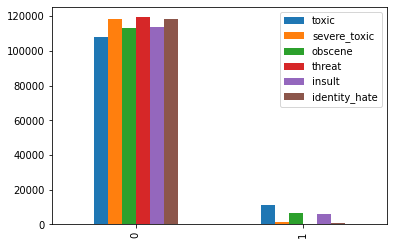

In [20]:
value_counts_train.T.plot(kind='bar')

In [21]:
unlabelled_in_all = y_train[(y_train['toxic']!=1) & (y_train['severe_toxic']!=1) & (y_train['obscene']!=1) & 
                            (y_train['threat']!=1) & (y_train['insult']!=1) & (y_train['identity_hate']!=1)]
print('Percentage of unlabelled comments is ', round(len(unlabelled_in_all)/len(train)*100))

Percentage of unlabelled comments is  67


In [22]:
#Total rows in train
print('Total rows in X_train is {}'.format(len(X_train)))

Total rows in X_train is 119678


In [23]:
y_train[y_train[target_classes].sum(axis=1)>0]

toxic  severe_toxic  obscene  threat  insult  identity_hate
65786       1             0        0       0       0              0
52799       1             0        1       0       0              0
34637       1             0        1       0       1              0
80878       1             0        1       0       1              0
77998       0             0        1       0       0              0
...       ...           ...      ...     ...     ...            ...
92160       1             0        0       0       1              0
21248       1             0        0       0       0              0
157375      1             0        0       0       0              0
57030       1             0        1       0       1              0
5078        1             0        0       0       0              0

[12170 rows x 6 columns]

You can see here that some labels can be assigned to more than one class

#### The Text Data:

An initial look will examine frequency distributions

In [24]:
# Get all the stop words in the English language
stopwords_list = stopwords.words('english')

# It is generally a good idea to also remove punctuation

# Now we have a list that includes all english stopwords, as well as all punctuation
stopwords_list += list(string.punctuation)

In [25]:
text = str(list(X_train))

### Tokenizing initial set of text corpus to develop stopword list:
(Takes 2 Min)

In [26]:
import functions as fn

2020-06-11 05:04:40.484094-07:00
[i] Timer started at06/11/20 - 05:04 AM
[i] Timer ended at 06/11/20 - 05:04 AM
- Total time = 0:00:00


In [27]:
timer = fn.Timer()

timer.start()
tokens = word_tokenize(text)
timer.stop()

[i] Timer started at06/11/20 - 05:04 AM
[i] Timer ended at 06/11/20 - 05:06 AM
- Total time = 0:01:41.058509


In [28]:
# Get all the stop words in the English language
stopwords_list = stopwords.words('english')

#remove punctuation
stopwords_list += list(string.punctuation)
##adding adhoc all strings that don't appear to contribute, added 'article, page and wikipedia' iteratively as 
##these are parts of most comment strings
stopwords_list += ("''","``", "'s", "\\n\\n" , '...', 'i\\','\\n',
                   '•', "i", 'the', "'m", 'i\\', "'ve", "don\\'t",
                  "'re", "\\n\\ni", "it\\", "'ll", 'you\\', "'d", "n't",
                  '’', 'article', 'page', 'wikipedia') 

In [29]:
timer = fn.Timer()
timer.start()
stopped_tokens = [w.lower() for w in tokens if w.lower() not in stopwords_list]
timer.stop()

[i] Timer started at06/11/20 - 05:06 AM
[i] Timer ended at 06/11/20 - 05:06 AM
- Total time = 0:00:26.107139


In [30]:
len(stopped_tokens)

4117933

In [31]:
from nltk import FreqDist
freqdist = FreqDist(stopped_tokens)
most_common_stopped = freqdist.most_common(200)
most_common_stopped

[('talk', 25738),
 ('would', 22330),
 ('one', 20894),
 ('like', 20621),
 ('please', 18566),
 ('see', 15638),
 ('think', 15010),
 ('also', 14558),
 ('know', 14223),
 ('people', 13266),
 ('edit', 13070),
 ('use', 12121),
 ('articles', 11765),
 ('may', 11566),
 ('time', 11266),
 ('even', 9998),
 ('get', 9914),
 ('make', 9566),
 ('user', 9105),
 ('could', 9014),
 ('good', 8995),
 ('information', 8879),
 ('want', 8806),
 ('way', 8275),
 ('sources', 8180),
 ('deletion', 8123),
 ('name', 7998),
 ('wp', 7786),
 ('first', 7720),
 ('new', 7665),
 ('need', 7605),
 ('source', 7566),
 ('well', 7509),
 ('editing', 7496),
 ('say', 7456),
 ('section', 7370),
 ('image', 7360),
 ('help', 7334),
 ('go', 7318),
 ('pages', 7317),
 ('edits', 7208),
 ('thanks', 7110),
 ('made', 7009),
 ('much', 6996),
 ('many', 6937),
 ('used', 6868),
 ('really', 6843),
 ('find', 6768),
 ('deleted', 6612),
 ('discussion', 6546),
 ('work', 6443),
 ('point', 6249),
 ('fuck', 6241),
 ('since', 6165),
 ('add', 6145),
 ('right', 

In [32]:
X_train.head()

141712    Translatin, Please! \n\nDear Fellow Wikipedian...
65786     "\n\nwell first, ""accidental suicide"" made m...
157143    Kevin McKenzie \n\nHi. Thanks for your message...
52753     A tag has been placed on Golden Martin Awards,...
17385     "\n\nIf the IMF no longer uses the ""in transi...
Name: comment_text, dtype: object

### EDA: Looking Deeper at the classes:

In [111]:
train.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

In [184]:
df = train.copy()

In [185]:
df.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

In [186]:
x=df.iloc[:,2:].sum()
display(x)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [247]:
##need to develop this more

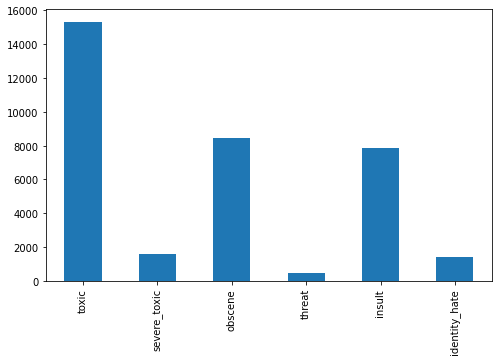

In [187]:
x.plot(kind='bar', figsize=(8,5))

Toxic is by far the highest occurance, and threats are significantly lower.

#### Examples of Varrying Toxic Text:

In [163]:
import matplotlib.pyplot as plt

In [117]:
#!pip install simple_colors

ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "C:\Users\aosika\AppData\Local\Continuum\anaconda3\envs\learn-env\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3012, in _dep_map
    return self.__dep_map
  File "C:\Users\aosika\AppData\Local\Continuum\anaconda3\envs\learn-env\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2806, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\aosika\AppData\Local\Continuum\anaconda3\envs\learn-env\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3003, in _parsed_pkg_info
    return self._pkg_info
  File "C:\Users\aosika\AppData\Local\Continuum\anaconda3\envs\learn-env\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2806, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

Durin

In [240]:
 from simple_colors import *

In [189]:
print(blue("Example of toxic text:",['bold']))
print(train[train['toxic']==1].iloc[2,1])
print('-----------------------------')
print(blue("Example of severe toxic text:",['bold']))
print(train[train['severe_toxic']==1].iloc[2,1])
print('-----------------------------')
print(blue("Example of obscene text:",['bold']))
print(train[train['obscene']==1].iloc[4,1])
print('-----------------------------')
print(blue("Example of threatening text:",['bold']))
print(train[train['threat']==1].iloc[2,1])
print('-----------------------------')
print(blue("Example of insulting text:",['bold']))
print(train[train['insult']==1].iloc[3,1])
print('-----------------------------')
print(blue("Example of identity hate based text:",['bold']))
print(train[train['identity_hate']==1].iloc[38,1])

Example of toxic text:
Bye! 

Don't look, come or think of comming back! Tosser.
-----------------------------
Example of severe toxic text:
you are a stupid fuck 

and your mother's cunt stinks
-----------------------------
Example of obscene text:
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!
-----------------------------
Example of threatening text:
I'm also a sock puppet of this account...SUPRISE!!
-sincerely,
            The man that will track you down from the Internet and kill you
-----------------------------
Example of insulting text:
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!
-----------------------------
Example of identity hate based text:
Niggers and their liberal friends steal everything not tied down, just like the presidency here with acorn with its liberal defenders, FUCK YOU NIGGER OBOAMA!


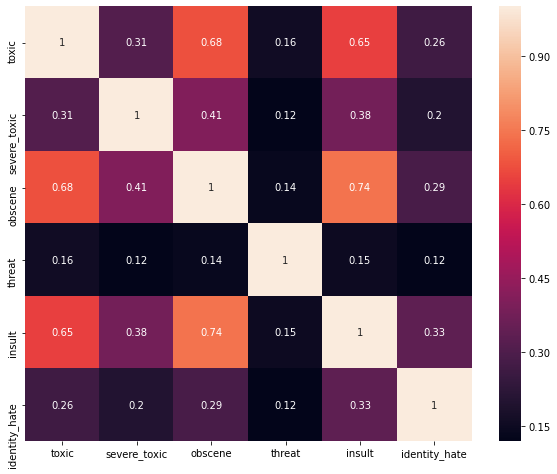

In [249]:
corr=y_train.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [190]:
#getting the totals from each row to identify if they had any toxic comments or not
rowtotals = train.iloc[:,2:].sum(axis=1)
df['clean_text'] = (rowtotals==0)
df['toxic_text'] = (rowtotals!=0)

In [199]:
print("Number of clean comments:", df['clean_text'].sum())
print("Number of toxic comments:", df['toxic_text'].sum())

Number of clean comments: 143346
Number of toxic comments: 16225


In [191]:
df.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  clean_text  \
0             0        0       0       0              0        True   
1             0        0       0       0              0        True   
2             0        0       0       0              0        True   
3             0        0       0       0              0        True   
4             0        0       0       0              0        True   

   toxic_text  
0       False  
1       False  
2       False  
3       False  
4       False

In [205]:
ToxicDf = df[(df['toxic'] == 1)]
SevTox = df[(df['severe_toxic'] == 1)]
Obs = df[(df['obscene'] == 1)]
Threat = df[(df['threat'] == 1)]
Inst = df[(df['insult'] == 1)]
IDH8 = df[(df['identity_hate']==1)]        

In [255]:
tox_obs = df[(df['toxic'] ==1) & (df['obscene'])]
len(tox_obs)

7926

In [266]:
print("Comments tagged as toxic:", (len(ToxicDf)))
print("Comments tagged as obscene:", (len(Obs)))
print("Comments tagged as toxic and obscene", len(tox_obs))
print("Percentage of comments tagged as toxic and obscene" )
print("compared to soley toxic", (round(len(tox_obs)/len(Obs),2)*100))

Comments tagged as toxic: 15294
Comments tagged as obscene: 8449
Comments tagged as toxic and obscene 7926
Percentage of comments tagged as toxic and obscene
compared to soley toxic 94.0


In [207]:
toxic_text = str(list(ToxicDf['comment_text']))
sev_toxic_text = str(list(SevTox['comment_text']))
obs_text = str(list(Obs['comment_text']))
threat_text = str(list(Threat['comment_text']))
insult_text = str(list(Inst['comment_text']))
idh8_text = str(list(IDH8['comment_text']))


'[\'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK\', \'Hey... what is it..\\n@ | talk .\\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\\n\\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...\', "Bye! \\n\\nDon\'t look, come or think of comming back! Tosser.", "You are gay or antisemmitian? \\n\\nArchangel WHite Tiger\\n\\nMeow! Greetingshhh!\\n\\nUh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...\\n\\n1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!\\n\\n2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!\\n\\n3 - First and last warning, you fucking gay - I won

In [211]:
from importlib import reload

In [220]:
def tok_text(text):
    from nltk import word_tokenize
    
    tokens = word_tokenize(text)
    stopped_tokens = [w.lower() for w in tokens if w.lower() not in stopwords_list]
    return(stopped_tokens)

In [223]:
def freq_dist(tokens):
    freqdist = FreqDist(tokens)
    most_common_stopped = freqdist.most_common(100)
    return most_common_stopped

##### Toxic:

In [221]:
tox_toks = tok_text(toxic_text)

In [270]:
freq_tox = freq_dist(tox_toks)
dict(freq_tox)

{'fuck': 8316,
 'like': 3458,
 'shit': 3282,
 'nigger': 3243,
 'suck': 3136,
 'fucking': 3118,
 'ass': 2856,
 'hate': 2600,
 'u': 2587,
 'go': 2546,
 'know': 2177,
 'get': 2147,
 'gay': 2070,
 'fat': 1953,
 'faggot': 1908,
 'die': 1870,
 'moron': 1843,
 'people': 1808,
 'bitch': 1668,
 'hi': 1544,
 'one': 1440,
 'cunt': 1435,
 'stupid': 1383,
 'pig': 1344,
 'jew': 1327,
 'talk': 1319,
 'think': 1224,
 'want': 1208,
 'sucks': 1194,
 'stop': 1149,
 'wiki': 1132,
 'dick': 1098,
 'would': 1080,
 'block': 1049,
 'wanker': 1019,
 'time': 1007,
 'life': 1005,
 'bark': 1000,
 'even': 992,
 'balls': 987,
 'fag': 986,
 'dont': 974,
 'going': 946,
 'sex': 928,
 'make': 923,
 'cock': 906,
 'edit': 898,
 'vandalism': 898,
 'right': 897,
 'see': 872,
 'little': 842,
 'piece': 841,
 'user': 822,
 'nipple': 822,
 'asshole': 804,
 'really': 797,
 'penis': 797,
 'kill': 788,
 'aids': 779,
 'hell': 767,
 'dickhead': 750,
 'good': 749,
 "'fuck": 732,
 'fucker': 730,
 'care': 727,
 'say': 725,
 'bastard': 

In [271]:
replace = {'fuck': 'f$%!', 'nigger' : 'n*$$#@' }

In [273]:
new_dict = {}
for k, v in dict(freq_tox).items():
    if k in replace:
        key = replace[k]
    else:
        key = k
        
    new_dict[key] = v
    
    

In [274]:
new_dict

{'f$%!': 8316,
 'like': 3458,
 'shit': 3282,
 'n*$$#@': 3243,
 'suck': 3136,
 'fucking': 3118,
 'ass': 2856,
 'hate': 2600,
 'u': 2587,
 'go': 2546,
 'know': 2177,
 'get': 2147,
 'gay': 2070,
 'fat': 1953,
 'faggot': 1908,
 'die': 1870,
 'moron': 1843,
 'people': 1808,
 'bitch': 1668,
 'hi': 1544,
 'one': 1440,
 'cunt': 1435,
 'stupid': 1383,
 'pig': 1344,
 'jew': 1327,
 'talk': 1319,
 'think': 1224,
 'want': 1208,
 'sucks': 1194,
 'stop': 1149,
 'wiki': 1132,
 'dick': 1098,
 'would': 1080,
 'block': 1049,
 'wanker': 1019,
 'time': 1007,
 'life': 1005,
 'bark': 1000,
 'even': 992,
 'balls': 987,
 'fag': 986,
 'dont': 974,
 'going': 946,
 'sex': 928,
 'make': 923,
 'cock': 906,
 'edit': 898,
 'vandalism': 898,
 'right': 897,
 'see': 872,
 'little': 842,
 'piece': 841,
 'user': 822,
 'nipple': 822,
 'asshole': 804,
 'really': 797,
 'penis': 797,
 'kill': 788,
 'aids': 779,
 'hell': 767,
 'dickhead': 750,
 'good': 749,
 "'fuck": 732,
 'fucker': 730,
 'care': 727,
 'say': 725,
 'bastard': 

In [ ]:
wordcloud.generate_from_frequencies(',')

(-0.5, 399.5, 199.5, -0.5)

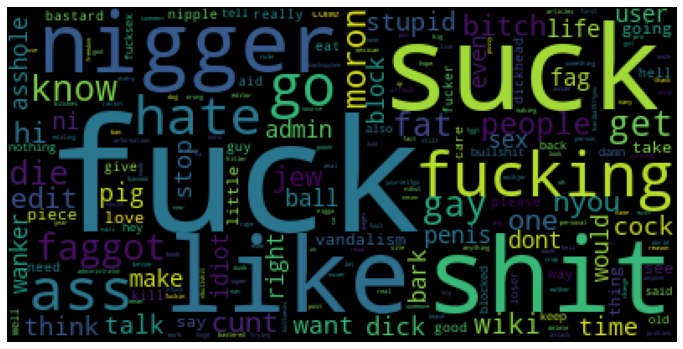

In [225]:
import wordcloud
from wordcloud import WordCloud
wordcloud = WordCloud(stopwords=stopwords_list,collocations=False)
wordcloud.generate(','.join(tox_toks))
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off')

##### Severe Toxic

In [231]:
sev_tox_toks = tok_text(sev_toxic_text)

In [232]:
freq_sev_tox = freq_dist(sev_tox_toks)
freq_sev_tox

[('fuck', 6163),
 ('suck', 2486),
 ('ass', 2100),
 ('shit', 1864),
 ('faggot', 1491),
 ('u', 1437),
 ('fucking', 1334),
 ('go', 1157),
 ('bitch', 1057),
 ('nigger', 977),
 ('die', 961),
 ('cunt', 784),
 ('sucks', 730),
 ('cock', 675),
 ('fucksex', 624),
 ('yourselfgo', 621),
 ('fucker', 584),
 ('kill', 577),
 ("'fuck", 517),
 ('cocksucker', 507),
 ('piece', 501),
 ('mothjer', 489),
 ('dick', 483),
 ('gay', 468),
 ('bastard', 448),
 ('huge', 423),
 ('fat', 406),
 ('damn', 396),
 ('rape', 382),
 ('dog', 373),
 ('offfuck', 360),
 ('stupid', 358),
 ('mexicans', 355),
 ('pro-assad.hanibal911you', 345),
 ('\\nshut', 343),
 ('like', 339),
 ('niggas', 337),
 ('dickhead', 333),
 ('bitches.fuck', 333),
 ('pussy', 329),
 ('asshole', 328),
 ('anal', 316),
 ('block', 314),
 ('eat', 312),
 ('get', 310),
 ('criminalwar', 279),
 ('bunksteve', 277),
 ('going', 273),
 ('cocksucking', 272),
 ('chester', 261),
 ('marcolfuck', 260),
 ('want', 257),
 ('penis/////small', 249),
 ('cocks', 232),
 ('useless', 2

(-0.5, 399.5, 199.5, -0.5)

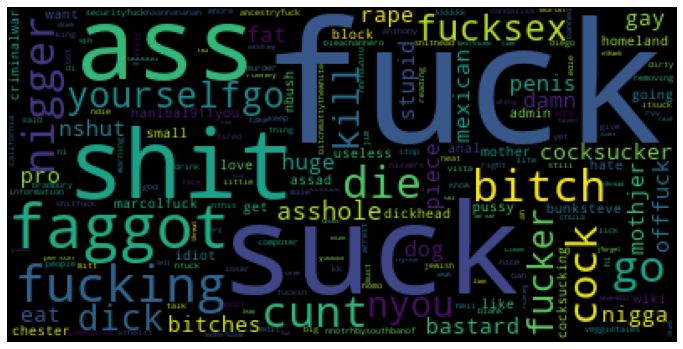

In [228]:
wordcloud = WordCloud(stopwords=stopwords_list,collocations=False)
wordcloud.generate(','.join(sev_tox_toks))
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off')

##### Obscene

In [235]:
obs_toks = tok_text(obs_text)

In [236]:
obs_tox = freq_dist(obs_toks)

(-0.5, 399.5, 199.5, -0.5)

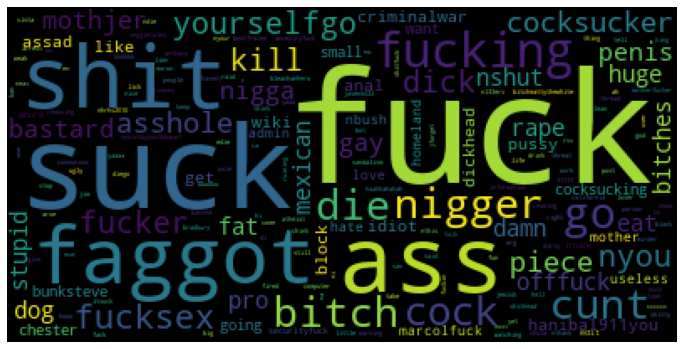

In [239]:
wordcloud = WordCloud(stopwords=stopwords_list,collocations=False)
wordcloud.generate(','.join(sev_tox_toks))
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off')

##### Threat

In [241]:
threat_toks = tok_text(threat_text)

In [242]:
threat_tox = freq_dist(threat_toks)

(-0.5, 399.5, 199.5, -0.5)

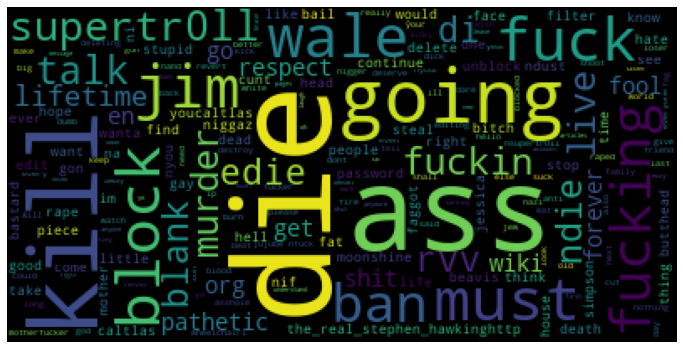

In [243]:
wordcloud = WordCloud(stopwords=stopwords_list,collocations=False)
wordcloud.generate(','.join(threat_toks))
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off')

###### Insult

In [244]:
inslt_toks = tok_text(insult_text)

In [245]:
inslt_tox = freq_dist(inslt_toks)

(-0.5, 399.5, 199.5, -0.5)

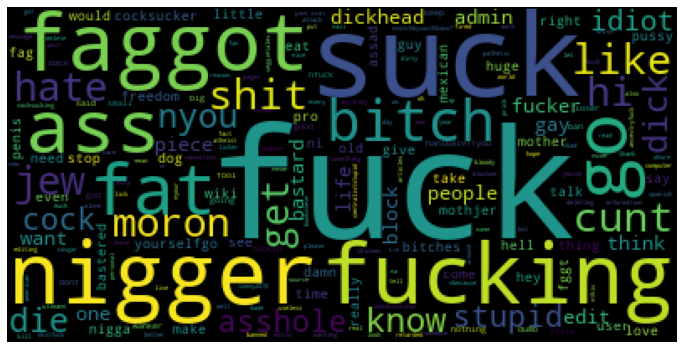

In [246]:
wordcloud = WordCloud(stopwords=stopwords_list,collocations=False)
wordcloud.generate(','.join(inslt_toks))
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off')

##### Identity_hate

In [250]:
idh8_toks = tok_text(idh8_text)

In [253]:
idh8_tox = freq_dist(idh8_toks)
idh8_tox

[('nigger', 2919),
 ('fat', 1318),
 ('jew', 1302),
 ('gay', 887),
 ('fuck', 785),
 ('faggot', 726),
 ('die', 695),
 ('fucking', 502),
 ('huge', 428),
 ('suck', 419),
 ('shit', 401),
 ('stupid', 391),
 ('cunt', 391),
 ('like', 378),
 ('ass', 366),
 ('mexicans', 362),
 ('niggas', 341),
 ('bitch', 325),
 ('hate', 288),
 ('bunksteve', 277),
 ('go', 256),
 ('get', 233),
 ('tommy2010', 226),
 ('ancestryfuck-off-jewish', 207),
 ('u', 201),
 ('\\nyou', 197),
 ('kill', 196),
 ('licker', 181),
 ('spanish', 181),
 ('centraliststupid', 179),
 ('fan-1967', 176),
 ('jews', 174),
 ('people', 174),
 ('piece', 171),
 ('keep', 167),
 ('ca', 167),
 ('drink', 151),
 ('bleachanhero', 148),
 ('homo', 122),
 ('know', 115),
 ('niggers', 110),
 ('nigga\\n\\neat', 108),
 ('would', 105),
 ('think', 105),
 ('make', 103),
 ('utc', 102),
 ('nl33ers\\ni', 100),
 ('one', 99),
 ('little', 98),
 ('right', 96),
 ('want', 94),
 ('\\ncody', 92),
 ('di', 90),
 ('edie', 90),
 ('mitt', 89),
 ('romney', 89),
 ('stop', 86),
 (

(-0.5, 399.5, 199.5, -0.5)

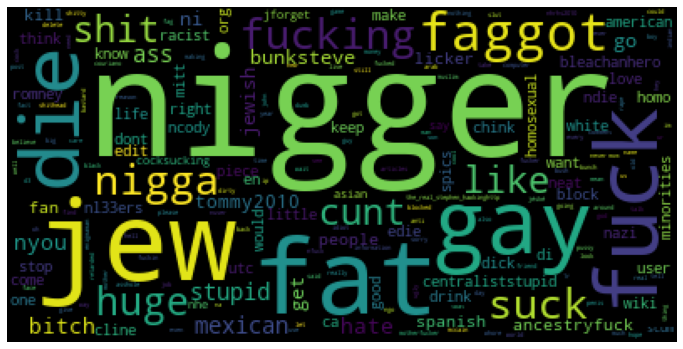

In [252]:
wordcloud = WordCloud(stopwords=stopwords_list,collocations=False)
wordcloud.generate(','.join(idh8_toks))
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off')

## Modeling:

In [33]:
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
#https://github.com/learn-co-students/dsc-classification-with-word-embeddings-codealong-online-ds-pt-100719
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

Using TensorFlow backend.


I had the same problem and solved it using TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=10)
(In this case, I ignore terms that have a document frequency strictly lower than 10)

In [34]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
#try texts_to_matrix
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

In [35]:
comments = [len(comment) for comment in list_tokenized_train]

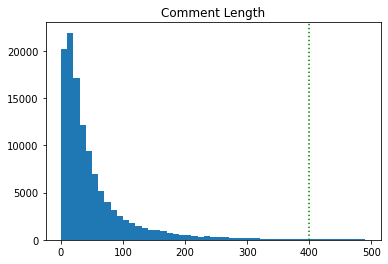

In [36]:
plt.hist(comments,bins = np.arange(0,500,10))
plt.axvline(x=400, color='g', ls=':')
plt.title('Comment Length')
plt.show()

In [37]:
#Average comment block is ~ 30 will capture the majority with 400

In [38]:
maxlen = 400
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [39]:
X_t.shape[1]

400

In [40]:
type(X_t)

numpy.ndarray

### Vanilla Neural Network: Keras 

In [42]:
van_model = Sequential()

In [43]:
van_model.add(Dense(10, activation='relu', input_shape=(X_t.shape[1],) ))
van_model.add(Dense(6, activation='sigmoid'))

In [44]:
van_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [45]:
van_history = van_model.fit(X_t, y_train, epochs=10,
                            batch_size=200,
                            validation_split=.2)

Train on 95742 samples, validate on 23936 samples
Epoch 1/10
95742/95742 [==============================] - 1s 14us/step - loss: 0.8444 - accuracy: 0.9614 - val_loss: 0.5543 - val_accuracy: 0.9622
Epoch 2/10
95742/95742 [==============================] - 1s 12us/step - loss: 0.5013 - accuracy: 0.9636 - val_loss: 0.4571 - val_accuracy: 0.9623
Epoch 3/10
95742/95742 [==============================] - 1s 12us/step - loss: 0.4197 - accuracy: 0.9636 - val_loss: 0.3902 - val_accuracy: 0.9623
Epoch 4/10
95742/95742 [==============================] - 1s 10us/step - loss: 0.3624 - accuracy: 0.9636 - val_loss: 0.3423 - val_accuracy: 0.9623
Epoch 5/10
95742/95742 [==============================] - 1s 12us/step - loss: 0.3209 - accuracy: 0.9636 - val_loss: 0.3073 - val_accuracy: 0.9623
Epoch 6/10
95742/95742 [==============================] - 1s 10us/step - loss: 0.2901 - accuracy: 0.9636 - val_loss: 0.2812 - val_accuracy: 0.9623
Epoch 7/10
95742/95742 [==============================] - 1s 12us/st

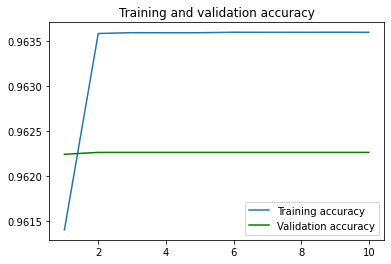

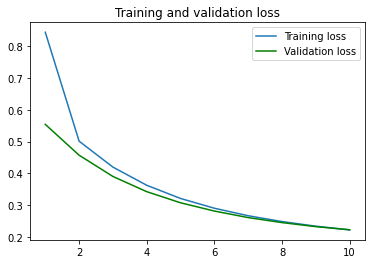

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline 

acc = van_history.history['accuracy']
val_acc = van_history.history['val_accuracy']
loss = van_history.history['loss']
val_loss = van_history.history['val_loss']
epochs = range(1, len(acc) +1)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc,color='g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, color='g' , label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [47]:
def plot_loss_acc(history):
    import matplotlib.pyplot as plt
    %matplotlib inline 

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) +1)
    plt.plot(epochs, acc, label='Training accuracy')
    plt.plot(epochs, val_acc,color='g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, color='g' , label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

#### Vanilla Neural Network Observations:

Initialized a very small and shallow 'vanilla' model to observe convergence trends and behavior.  Zero response from validation data and model overtrains by second epoch.

### RNN: LSTM_60_50_6

Implementing LSTM and dropout to see if there's improvement.:
**Run Time is 1 Hour 45 Min**

In [49]:
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers




In [50]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=3), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [56]:
rnn = Sequential()
embedding_size = 128

rnn.add(Embedding(max_features, embedding_size, input_length=X_t.shape[1] ))
#adding LSTM layer to help 'forget' then pooling
rnn.add(LSTM(60, return_sequences=True, name='lstm_layer'))
rnn.add(GlobalMaxPool1D())
rnn.add(Dropout(0.1))  
rnn.add(Dense(20, activation='relu',kernel_regularizer=regularizers.l2(.0001) ))
rnn.add(Dropout(0.1))
rnn.add(Dense(6, activation='sigmoid'))

In [58]:
rnn.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [59]:
rnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 400, 128)          256000    
_________________________________________________________________
lstm_layer (LSTM)            (None, 400, 60)           45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1220      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                

In [60]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=3), 
                  ModelCheckpoint(filepath='best_model.h5', 
                                  monitor='val_loss', 
                                  save_best_only=True)]

In [61]:
## WARNING ⏰ 1 Hr 45 min+ RunTime ⏰
#fit the model
timer = fn.Timer()
timer.start()
history = rnn.fit(X_t, y_train, epochs=10, 
                  callbacks=early_stopping,
                  batch_size=300, validation_split=0.2)
timer = timer.stop()

[i] Timer started at06/11/20 - 07:02 AM


C:\Users\aosika\AppData\Local\Continuum\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 95742 samples, validate on 23936 samples
Epoch 1/10
95742/95742 [==============================] - 673s 7ms/step - loss: 0.2174 - accuracy: 0.9290 - val_loss: 0.1148 - val_accuracy: 0.9624
Epoch 2/10
95742/95742 [==============================] - 669s 7ms/step - loss: 0.0743 - accuracy: 0.9761 - val_loss: 0.0623 - val_accuracy: 0.9794
Epoch 3/10
95742/95742 [==============================] - 617s 6ms/step - loss: 0.0610 - accuracy: 0.9802 - val_loss: 0.0610 - val_accuracy: 0.9799
Epoch 4/10
95742/95742 [==============================] - 615s 6ms/step - loss: 0.0585 - accuracy: 0.9808 - val_loss: 0.0603 - val_accuracy: 0.9803
Epoch 5/10
95742/95742 [==============================] - 616s 6ms/step - loss: 0.0567 - accuracy: 0.9812 - val_loss: 0.0598 - val_accuracy: 0.9802
Epoch 6/10
95742/95742 [==============================] - 634s 7ms/step - loss: 0.0553 - accuracy: 0.9812 - val_loss: 0.0605 - val_accuracy: 0.9801
Epoch 7/10
95742/95742 [==============================] - 617s

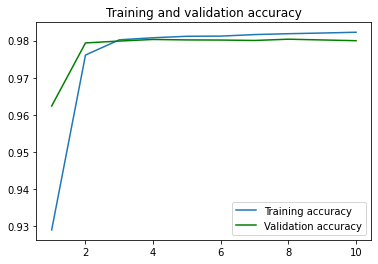

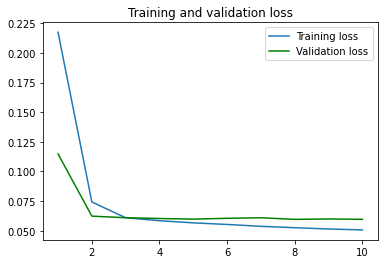

In [62]:
plot_loss_acc(history)

In [63]:
y_h_train_probs = rnn.predict(X_t)

In [64]:
y_hat_test_proba = rnn.predict(X_te)
y_hat_test_proba[1]

array([2.4406612e-03, 7.8289304e-06, 3.4850836e-04, 9.0457506e-06,
       1.7875433e-04, 1.0120201e-04], dtype=float32)

In [65]:
y_preds = pd.DataFrame(np.round(y_hat_test_proba), columns=target_classes)

In [66]:
y_preds_train = pd.DataFrame(np.round(y_h_train_probs), columns=target_classes)

In [67]:
y_preds

toxic  severe_toxic  obscene  threat  insult  identity_hate
0        0.0           0.0      0.0     0.0     0.0            0.0
1        0.0           0.0      0.0     0.0     0.0            0.0
2        0.0           0.0      0.0     0.0     0.0            0.0
3        0.0           0.0      0.0     0.0     0.0            0.0
4        0.0           0.0      0.0     0.0     0.0            0.0
...      ...           ...      ...     ...     ...            ...
39888    0.0           0.0      0.0     0.0     0.0            0.0
39889    0.0           0.0      0.0     0.0     0.0            0.0
39890    0.0           0.0      0.0     0.0     0.0            0.0
39891    1.0           0.0      1.0     0.0     1.0            0.0
39892    1.0           0.0      0.0     0.0     0.0            0.0

[39893 rows x 6 columns]

In [68]:
y_preds.shape

(39893, 6)

In [69]:
y_test.shape

(39893, 6)

In [70]:
val_counts_y_preds = y_preds.apply(pd.Series.value_counts)
val_counts

toxic  severe_toxic  obscene  threat  insult  identity_hate
0  108204        118467   113329  119322  113782         118647
1   11474          1211     6349     356    5896           1031

In [71]:
y_train.shape[1]

6

In [72]:
from sklearn.metrics import classification_report, confusion_matrix

Training Data Outcomes:

In [73]:
for i in range(0,y_train.shape[1]):
    y_i_hat_t = y_preds_train.iloc[:,i]
    y_i_t = y_train.iloc[:,i]
    print(y_train.columns[i])
    print(classification_report(y_i_hat_t, y_i_t))

toxic
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98    110444
         1.0       0.71      0.88      0.78      9234

    accuracy                           0.96    119678
   macro avg       0.85      0.92      0.88    119678
weighted avg       0.97      0.96      0.96    119678

severe_toxic
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    118984
         1.0       0.33      0.58      0.43       694

    accuracy                           0.99    119678
   macro avg       0.67      0.79      0.71    119678
weighted avg       0.99      0.99      0.99    119678

obscene
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    114286
         1.0       0.75      0.88      0.81      5392

    accuracy                           0.98    119678
   macro avg       0.87      0.94      0.90    119678
weighted avg       0.98      0.98      0.98    

C:\Users\aosika\AppData\Local\Continuum\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    119678
         1.0       0.00      0.00      0.00         0

    accuracy                           1.00    119678
   macro avg       0.50      0.50      0.50    119678
weighted avg       1.00      1.00      1.00    119678

insult
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    114595
         1.0       0.66      0.76      0.71      5083

    accuracy                           0.97    119678
   macro avg       0.82      0.87      0.85    119678
weighted avg       0.98      0.97      0.97    119678

identity_hate
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    119656
         1.0       0.01      0.45      0.02        22

    accuracy                           0.99    119678
   macro avg       0.50      0.72      0.51    119678
weighted avg       1.00      0.99      1.00    119678

Test Data Outcomes:
    

In [74]:
for i in range(0,y_train.shape[1]):
    y_i_hat = y_preds.iloc[:,i]
    y_i = y_test.iloc[:,i]
    print(y_train.columns[i])
    print(classification_report(y_i, y_i_hat))

toxic
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     36073
           1       0.83      0.67      0.74      3820

    accuracy                           0.95     39893
   macro avg       0.90      0.83      0.86     39893
weighted avg       0.95      0.95      0.95     39893

severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     39509
           1       0.51      0.28      0.37       384

    accuracy                           0.99     39893
   macro avg       0.75      0.64      0.68     39893
weighted avg       0.99      0.99      0.99     39893

obscene
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     37793
           1       0.86      0.72      0.79      2100

    accuracy                           0.98     39893
   macro avg       0.92      0.86      0.89     39893
weighted avg       0.98      0.98      0.98    

C:\Users\aosika\AppData\Local\Continuum\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      0.99      0.98     37912
           1       0.73      0.62      0.67      1981

    accuracy                           0.97     39893
   macro avg       0.86      0.80      0.83     39893
weighted avg       0.97      0.97      0.97     39893

identity_hate
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     39519
           1       0.54      0.02      0.04       374

    accuracy                           0.99     39893
   macro avg       0.76      0.51      0.52     39893
weighted avg       0.99      0.99      0.99     39893



In [75]:
y_test.head()

toxic  severe_toxic  obscene  threat  insult  identity_hate
103771      0             0        0       0       0              0
108885      0             0        0       0       0              0
146115      0             0        0       0       0              0
122666      0             0        0       0       0              0
133968      0             0        0       0       0              0

In [78]:
#confusion_matrix(y_i_hat,y_i_t, normalize=False)

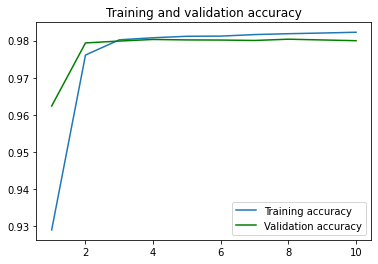

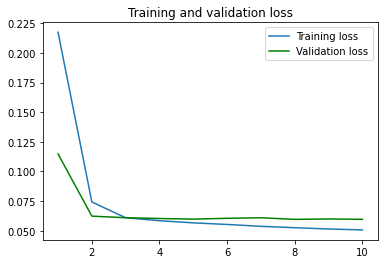

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) +1)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc,color='g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, color='g' , label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### RNN_LSTM_tiny_10_5_6

In [80]:
rnn_tiny = Sequential()
embedding_size = 128

rnn_tiny.add(Embedding(max_features, embedding_size))
#adding LSTM layer to help 'forget' then pooling
rnn_tiny.add(LSTM(10, return_sequences=True,name='lstm_layer'))        
rnn_tiny.add(GlobalMaxPool1D())
rnn_tiny.add(Dropout(0.1))  
rnn_tiny.add(Dense(5, activation='relu',kernel_regularizer=regularizers.l2(.0001) ))
rnn_tiny.add(Dropout(0.1))
rnn_tiny.add(Dense(6, activation='sigmoid'))

In [81]:
rnn_tiny.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [82]:
## WARNING ⏰ 1 Hour RunTime ⏰
#fit the model
timer = fn.Timer()
timer.start()
history_tiny_rnn = rnn_tiny.fit(X_t, y_train, epochs=20, 
                       batch_size=200, 
                       callbacks=early_stopping,
                       validation_split=0.2)
timer = timer.stop()

[i] Timer started at06/11/20 - 09:12 AM
Train on 95742 samples, validate on 23936 samples
Epoch 1/20
95742/95742 [==============================] - 328s 3ms/step - loss: 0.1814 - accuracy: 0.9529 - val_loss: 0.1304 - val_accuracy: 0.9624
Epoch 2/20
95742/95742 [==============================] - 357s 4ms/step - loss: 0.0913 - accuracy: 0.9711 - val_loss: 0.0641 - val_accuracy: 0.9790
Epoch 3/20
95742/95742 [==============================] - 330s 3ms/step - loss: 0.0639 - accuracy: 0.9795 - val_loss: 0.0627 - val_accuracy: 0.9797
Epoch 4/20
95742/95742 [==============================] - 353s 4ms/step - loss: 0.0612 - accuracy: 0.9800 - val_loss: 0.0617 - val_accuracy: 0.9798
Epoch 5/20
95742/95742 [==============================] - 298s 3ms/step - loss: 0.0587 - accuracy: 0.9804 - val_loss: 0.0615 - val_accuracy: 0.9799
Epoch 6/20
95742/95742 [==============================] - 283s 3ms/step - loss: 0.0572 - accuracy: 0.9808 - val_loss: 0.0619 - val_accuracy: 0.9798
Epoch 7/20
95742/95742

In [83]:
# list all data in history
print(history_tiny_rnn.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


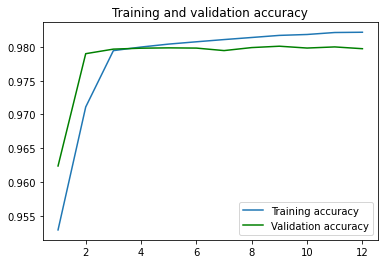

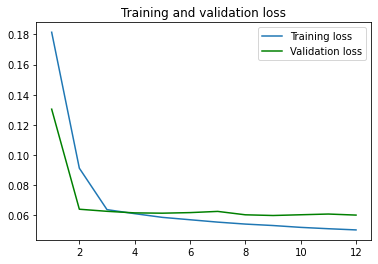

In [84]:
plot_loss_acc(history_tiny_rnn)

In [85]:
y_hat_test_proba_trnn = rnn.predict(X_te)
y_hat_test_proba_trnn[1]

array([2.4406612e-03, 7.8289304e-06, 3.4850836e-04, 9.0457506e-06,
       1.7875433e-04, 1.0120201e-04], dtype=float32)

In [297]:
y_hat_proba_tiny = rnn_tiny.predict(X_te)

In [298]:
y_preds_tiny = pd.DataFrame(np.round(y_hat_proba_tiny), columns=target_classes)

In [299]:
for i in range(0,y_train.shape[1]):
    y_i_hat_trnn = y_preds_tiny.iloc[:,i]
    y_i_trnn = y_test.iloc[:,i]
    print(y_train.columns[i])
    print(classification_report(y_i_trnn, y_i_hat_trnn))

toxic
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     36073
           1       0.80      0.68      0.74      3820

    accuracy                           0.95     39893
   macro avg       0.88      0.83      0.86     39893
weighted avg       0.95      0.95      0.95     39893

severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     39509
           1       0.55      0.21      0.30       384

    accuracy                           0.99     39893
   macro avg       0.77      0.60      0.65     39893
weighted avg       0.99      0.99      0.99     39893

obscene
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     37793
           1       0.83      0.74      0.78      2100

    accuracy                           0.98     39893
   macro avg       0.91      0.87      0.89     39893
weighted avg       0.98      0.98      0.98    

### RNN_small_20_10_6

In [87]:
from tensorflow.keras import regularizers

In [88]:
rnn_small = Sequential()
embedding_size = 128

rnn_small.add(Embedding(max_features, embedding_size))
#adding LSTM layer to help 'forget' then pooling
rnn_small.add(LSTM(20, return_sequences=True,name='lstm_layer'))        
rnn_small.add(GlobalMaxPool1D())
rnn_small.add(Dropout(0.1))  
rnn_small.add(Dense(10, kernel_regularizer=regularizers.l2(.0001),activation='relu'))
rnn_small.add(Dropout(0.1))
rnn_small.add(Dense(6, activation='sigmoid'))

In [89]:
rnn_small.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [90]:
## WARNING ⏰ 30 Min+ RunTime ⏰
#fit the model
timer = fn.Timer()
timer.start()
history = rnn_small.fit(X_t, y_train, epochs=20, batch_size=300, 
                        callbacks=early_stopping, validation_split=0.2)
timer = timer.stop()

[i] Timer started at06/11/20 - 10:14 AM
Train on 95742 samples, validate on 23936 samples
Epoch 1/20
95742/95742 [==============================] - 272s 3ms/step - loss: 0.3053 - accuracy: 0.8844 - val_loss: 0.0882 - val_accuracy: 0.9624
Epoch 2/20
95742/95742 [==============================] - 368s 4ms/step - loss: 0.0799 - accuracy: 0.9722 - val_loss: 0.0686 - val_accuracy: 0.9760
Epoch 3/20
95742/95742 [==============================] - 334s 3ms/step - loss: 0.0673 - accuracy: 0.9783 - val_loss: 0.0636 - val_accuracy: 0.9796
Epoch 4/20
95742/95742 [==============================] - 346s 4ms/step - loss: 0.0618 - accuracy: 0.9799 - val_loss: 0.0621 - val_accuracy: 0.9796
Epoch 5/20
95742/95742 [==============================] - 324s 3ms/step - loss: 0.0592 - accuracy: 0.9803 - val_loss: 0.0627 - val_accuracy: 0.9793
Epoch 6/20
95742/95742 [==============================] - 318s 3ms/step - loss: 0.0579 - accuracy: 0.9805 - val_loss: 0.0622 - val_accuracy: 0.9796
Epoch 7/20
95742/95742

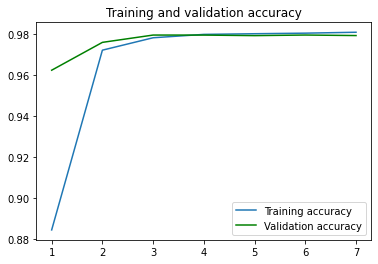

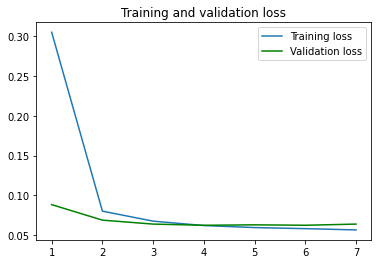

In [91]:
plot_loss_acc(history)

In [277]:
from sklearn.metrics import confusion_matrix

In [291]:
y_hat_test_proba_small = rnn_small.predict(X_te)


In [303]:
y_preds_small = pd.DataFrame(np.round(y_hat_test_proba_small), columns=target_classes)

In [304]:
for i in range(0,y_train.shape[1]):
    y_i_hat_small = y_preds_small.iloc[:,i]
    y_i = y_test.iloc[:,i]
    print(y_train.columns[i])
    print(classification_report(y_i, y_i_hat_small))

toxic
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     36073
           1       0.87      0.61      0.72      3820

    accuracy                           0.95     39893
   macro avg       0.92      0.80      0.85     39893
weighted avg       0.95      0.95      0.95     39893

severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     39509
           1       0.00      0.00      0.00       384

    accuracy                           0.99     39893
   macro avg       0.50      0.50      0.50     39893
weighted avg       0.98      0.99      0.99     39893

obscene
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     37793
           1       0.86      0.69      0.77      2100

    accuracy                           0.98     39893
   macro avg       0.92      0.84      0.88     39893
weighted avg       0.98      0.98      0.98    

In [305]:
for i in range(0,y_train.shape[1]):
    y_i_hat_sm = y_preds_small.iloc[:,i]
    y_i_t = y_train.iloc[:,i]
    print(y_train.columns[i])
    print(confusion_matrix(y_i, y_i_hat_sm,normalize='true'))
    print()

toxic
[[0.93911789 0.06088211]
 [0.26470588 0.73529412]]

severe_toxic
[[1. 0.]
 [1. 0.]]

obscene
[[0.9628027  0.0371973 ]
 [0.40641711 0.59358289]]

threat
[[1. 0.]
 [1. 0.]]

insult
[[0.96485235 0.03514765]
 [0.42780749 0.57219251]]

identity_hate
[[1. 0.]
 [1. 0.]]



In [248]:
import sklearn
sklearn.__version__

'0.22.1'

In [93]:
for i in range(0,y_train.shape[1]):
    y_i_hat_t = y_preds_train.iloc[:,i]
    y_i_t = y_train.iloc[:,i]
    print(y_train.columns[i])
    print(classification_report(y_i_hat_t, y_i_t))

toxic
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98    110444
         1.0       0.71      0.88      0.78      9234

    accuracy                           0.96    119678
   macro avg       0.85      0.92      0.88    119678
weighted avg       0.97      0.96      0.96    119678

severe_toxic
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    118984
         1.0       0.33      0.58      0.43       694

    accuracy                           0.99    119678
   macro avg       0.67      0.79      0.71    119678
weighted avg       0.99      0.99      0.99    119678

obscene
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    114286
         1.0       0.75      0.88      0.81      5392

    accuracy                           0.98    119678
   macro avg       0.87      0.94      0.90    119678
weighted avg       0.98      0.98      0.98    

## Conclusion:

## Appendix:

In [94]:
#! pip install wordcloud
import matplotlib.pyplot as plt

(-0.5, 399.5, 199.5, -0.5)

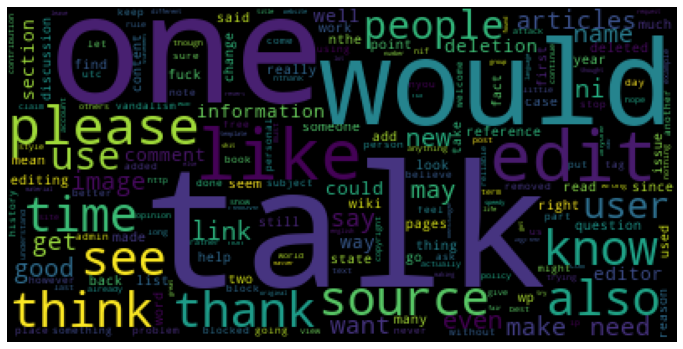

In [95]:
import wordcloud
from wordcloud import WordCloud
wordcloud = WordCloud(stopwords=stopwords_list,collocations=False)
wordcloud.generate(','.join(stopped_tokens))
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off')

In [96]:
print("toxic:")
print(train[train['toxic']==1].iloc[2,1])

toxic:
Bye! 

Don't look, come or think of comming back! Tosser.


In [97]:
train.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

In [109]:
print("Example of severe toxic text:")
print('\n')
print(train[train['severe_toxic']==1].iloc[4,1])

Example of severe toxic text:


What a motherfucking piece of crap those fuckheads for blocking us!


In [110]:
print("Example of obscene text:")
print('\n')
print(train[train['obscene']==1].iloc[4,1])

Example of obscene text:


Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!


In [99]:
X_train.head()

141712    Translatin, Please! \n\nDear Fellow Wikipedian...
65786     "\n\nwell first, ""accidental suicide"" made m...
157143    Kevin McKenzie \n\nHi. Thanks for your message...
52753     A tag has been placed on Golden Martin Awards,...
17385     "\n\nIf the IMF no longer uses the ""in transi...
Name: comment_text, dtype: object

In [100]:
X_train

141712    Translatin, Please! \n\nDear Fellow Wikipedian...
65786     "\n\nwell first, ""accidental suicide"" made m...
157143    Kevin McKenzie \n\nHi. Thanks for your message...
52753     A tag has been placed on Golden Martin Awards,...
17385     "\n\nIf the IMF no longer uses the ""in transi...
                                ...                        
80693     How perfectly elegant.\n\nThank you. 99.39.219...
143533    I did not use rollback, I simply reverted.  an...
58083     lead \n\nSomeone had tagged the lead as too lo...
89548     Rugby questions\nHi, I mainly find info on Sta...
23127     "\n\nViews on non-Muslims\nI'm adding some of ...
Name: comment_text, Length: 119678, dtype: object

NameError: name 'subset' is not defined

#### Toxic:

In [ ]:
train= pd.concat([X_train, y_train])
train.head()

In [ ]:
train['identity_hate'].value_counts()

In [ ]:
text = str(list(X_train))

In [ ]:
printext

In [ ]:
subset=y_train[y_train['severe_toxic']==1]
text= str(list(X_train))
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopwords_list)
wc.generate(" ".join(text))
plt.figure(figsize=(12,12))
plt.axis('off')
plt.title(f"Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wordcloud) 

In [ ]:
import seaborn as sns

In [256]:
def highlight_max(x):
    return ['background-color: yellow' if v == x.max() else ''
            for v in x]

In [275]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, 
# toxic is most frequent by far and 
main_col="toxic"
corr_mats=[]
for other_col in y_train.columns:
    confusion_mat = pd.crosstab(y_train[main_col], y_train[other_col])
    corr_mats.append(confusion_mat)
out = pd.concat(corr_mats,axis=1,keys=y_train)

#cell highlighting
out = out.style.apply(highlight_max,axis=0)
out

NameError: name 'train_feats' is not defined

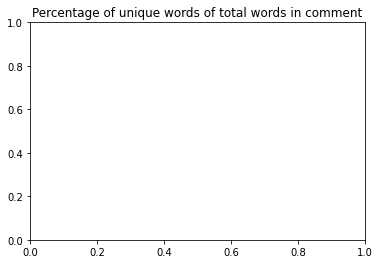

In [259]:
plt.title("Percentage of unique words of total words in comment")
#sns.boxplot(x='clean', y='word_unique_percent', data=train_feats)
ax=sns.kdeplot(train_feats[train_feats.clean == 0].word_unique_percent, label="Bad",shade=True,color='r')
ax=sns.kdeplot(train_feats[train_feats.clean == 1].word_unique_percent, label="Clean")
plt.legend()
plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('Percent unique words', fontsize=12)

In [ ]:
#squeaky clean
t=y_train.sum()
#marking comments without any tags as "clean"
rowsums=y_train.sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",t.sum())

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


def calc_loss(y_true, y_pred):
    return np.mean([log_loss(y_true[:, i], y_pred[:, i]) 
                    for i in range(y_true.shape[1])])